In [1]:
import $file.^.Magic

import $file.$

In [2]:
val zipName = "sms+spam+collection.zip"
val datasetUrl = s"https://archive.ics.uci.edu/static/public/228/$zipName"
val outputDir = "data/sms-spam-raw"

zipName: String = "sms+spam+collection.zip"
datasetUrl: String = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
outputDir: String = "data/sms-spam-raw"

In [3]:
Magic.!("curl", "--create-dirs", "-O", "--output-dir", outputDir, datasetUrl)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100   99k    0   99k    0     0  77139      0 --:--:--  0:00:01 --:--:-- 77110
100  198k    0  198k    0     0   146k      0 --:--:--  0:00:01 --:--:--  146k


In [4]:
Magic.!("unzip", "-o", s"$outputDir/$zipName", "-d", outputDir)

Archive:  data/sms-spam-raw/sms+spam+collection.zip
  inflating: data/sms-spam-raw/SMSSpamCollection  
  inflating: data/sms-spam-raw/readme  


In [5]:
import scala.io.Source

val datasetRaw = Source.fromFile(s"$outputDir/SMSSpamCollection").mkString

case class SmsSpamRecord(
  text: String,
  isSpam: Boolean
)

type Dataset = Vector[SmsSpamRecord]

val smsSpamRecords: Dataset = datasetRaw.split("\n").map {
  case s"spam\t$text" => SmsSpamRecord(text, isSpam = true)
  case s"ham\t$text" => SmsSpamRecord(text, isSpam = false)
}.toVector

val (spamRecords, notSpamRecords) = smsSpamRecords.partition(_.isSpam)
println(s"Spam count: ${spamRecords.size}")
println(s"Not spam count: ${notSpamRecords.size}")

Spam count: 747
Not spam count: 4827


import scala.io.Source
datasetRaw: String = """ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
ham	Ok lar... Joking wif u oni...
spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
ham	U dun say so early hor... U c already then say...
ham	Nah I don't think he goes to usf, he lives around here though
spam	FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv
ham	Even my brother is not like to speak with me. They treat me like aids patent.
ham	As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune
spam	WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim call 09061701461

In [6]:
import scala.collection.mutable
import scala.util.Random

val balancedDataset: Dataset = {

  def sample(records: Vector[SmsSpamRecord], targetSize: Int): Vector[SmsSpamRecord] = {
    val balancedDatasetSpam = mutable.Map[String, SmsSpamRecord]()
    while (balancedDatasetSpam.size < targetSize) {
      val randomRecord = records(Random.nextInt(records.size))
      if (!balancedDatasetSpam.contains(randomRecord.text))
        balancedDatasetSpam += randomRecord.text -> randomRecord
    }
    balancedDatasetSpam.values.toVector
  }

  if (spamRecords.size < notSpamRecords.size)
    spamRecords ++ sample(notSpamRecords, targetSize = spamRecords.size)
  else
    notSpamRecords ++ sample(spamRecords, targetSize = notSpamRecords.size)
}

import scala.collection.mutable
import scala.util.Random
balancedDataset: Dataset = Vector(
  SmsSpamRecord(
    text = "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's",
    isSpam = true
  ),
  SmsSpamRecord(
    text = "FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv",
    isSpam = true
  ),
  SmsSpamRecord(
    text = "WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.",
    isSpam = true
  ),
  SmsSpamRecord(
    text = "Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free! Call The Mobile Update Co FREE on 08002986030",
    isSpam = true
  ),
  SmsSpamRecord(
    text = "SIX chances to win CASH! From 100 to 20,000 po

In [7]:
type Training = Dataset
type Validation = Dataset
type Test = Dataset

def randomSplit(dataset: Vector[SmsSpamRecord], trainingFraction: Double, validationFraction: Double): (Training, Validation, Test) = {
  val shuffledDataset = Random.shuffle(dataset)
  val trainingSize = (shuffledDataset.size * trainingFraction).floor.toInt
  val validationSize = (shuffledDataset.size * validationFraction).floor.toInt

  val (training, remainingRecords) = shuffledDataset.splitAt(trainingSize)
  val (validation, test) = remainingRecords.splitAt(validationSize)
  (training, validation, test)
}

val (training, validation, test) = randomSplit(balancedDataset, trainingFraction = 0.7, validationFraction = 0.1) 

defined type Training
defined type Validation
defined type Test
defined function randomSplit
training: Training = Vector(
  SmsSpamRecord(
    text = "PRIVATE! Your 2003 Account Statement for 078",
    isSpam = true
  ),
  SmsSpamRecord(
    text = "Apart from the one i told you about yesterday?",
    isSpam = false
  ),
  SmsSpamRecord(
    text = "No 1 POLYPHONIC tone 4 ur mob every week! Just txt PT2 to 87575. 1st Tone FREE ! so get txtin now and tell ur friends. 150p/tone. 16 reply HL 4info",
    isSpam = true
  ),
  SmsSpamRecord(text = ";-) ok. I feel like john lennon.", isSpam = false),
  SmsSpamRecord(
    text = "Free video camera phones with Half Price line rental for 12 mths and 500 cross ntwk mins 100 txts. Call MobileUpd8 08001950382 or Call2OptOut/674",
    isSpam = true
  ),
  SmsSpamRecord(text = "Er yep sure. Props?", isSpam = false),
  SmsSpamRecord(text = "&lt;#&gt;  w jetton ave if you forgot", isSpam = false),
  SmsSpamRecord(text = "Detroit. The home of snow. Enjo

In [8]:
import $ivy.`com.github.tototoshi::scala-csv:2.0.0`

import scala.util.Using
import com.github.tototoshi.csv.CSVWriter

val textHeader = "Text"
val labelHeader = "Label"

def writeToCsv(path: String, dataset: Dataset): Unit = {
  val headers = Vector(textHeader, labelHeader)

  Using.resource(CSVWriter.open(path)) { writer =>
    val rows = dataset.map {
      case SmsSpamRecord(text, isSpam) => Vector(text, if (isSpam) "1" else "0")
    }
    writer.writeAll(headers +: rows)
  }
}

val trainingCsv = "data/training.csv"
writeToCsv(trainingCsv, training)
val validationCsv = "data/validation.csv"
writeToCsv(validationCsv, validation)
val testCsv = "data/test.csv"
writeToCsv(testCsv, test)

import $ivy.$
import scala.util.Using
import com.github.tototoshi.csv.CSVWriter
textHeader: String = "Text"
labelHeader: String = "Label"
defined function writeToCsv
trainingCsv: String = "data/training.csv"
validationCsv: String = "data/validation.csv"
testCsv: String = "data/test.csv"

In [9]:
Magic.!("pip", "install", "tiktoken==0.7.*")


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [10]:
import $ivy.`dev.scalapy::scalapy-core:0.5.3`

import me.shadaj.scalapy.py
import py.SeqConverters

val tiktoken = py.module("tiktoken")

val tokenizer = tiktoken.get_encoding("gpt2")
val endOfTextToken = "<|endoftext|>"
val encodedEndOfTextToken = tokenizer.encode(endOfTextToken, allowed_special = py.Dynamic.global.set(Seq(endOfTextToken).toPythonProxy))
println(encodedEndOfTextToken)

[50256]


import $ivy.$
import me.shadaj.scalapy.py
import py.SeqConverters
tiktoken: py.Module = <module 'tiktoken' from '/usr/local/lib/python3.12/site-packages/tiktoken/__init__.py'>
tokenizer: py.Dynamic = <Encoding 'gpt2'>
endOfTextToken: String = "<|endoftext|>"
encodedEndOfTextToken: py.Dynamic = [50256]

In [11]:
Magic.!("pip", "install", "torch==2.4.*")


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [12]:
import com.github.tototoshi.csv.CSVReader
import py.PyQuote

val torch = py.module("torch")

type Tokenizer = py.Dynamic

// Workaround to define a class that inherits from a Python class
py.exec {
  s"""from torch.utils.data import Dataset
     |
     |class SpamDataset(Dataset):
     |  def __init__(self, init):
     |    init(self)
     |
     |  def __getitem__(self, index):
     |    return self.getItem(index)
     |  
     |  def __len__(self):
     |    return self.len()
     |""".stripMargin
}
def SpamDataset(
  csvPath: String,
  tokenizer: Tokenizer,
  maxLength: Option[Int] = None,
  paddingTokenId: Int = 50_256
): py.Dynamic = {
  val smsSpamRecords = Using.resource(CSVReader.open(csvPath)) { csvReader =>
    csvReader.iteratorWithHeaders.map { row =>
      SmsSpamRecord(text = row(textHeader), isSpam = row(labelHeader).toInt > 0)
    }.toVector
  }
  val encodedTexts = {
    val encodedTexts = smsSpamRecords.map(_.text).map(tokenizer.encode(_).as[Seq[Int]].toVector)
    val padToLength = maxLength.getOrElse(encodedTexts.map(_.length).max)
    encodedTexts.map(_.padTo(padToLength, paddingTokenId))
  }
    
  val init = (self: py.Dynamic) => {
    self.maxLength = encodedTexts.head.length
    
    val getItem = (index: Int) => {
      val textTensor = torch.tensor(encodedTexts(index).toPythonProxy, dtype = torch.long)
      val labelTensor = torch.tensor(if (smsSpamRecords(index).isSpam) 1 else 0, dtype = torch.long)
      (textTensor, labelTensor)
    }
    self.getItem = getItem

    val len = () => smsSpamRecords.size
    self.len = len
  }
  py.Dynamic.global.SpamDataset(init)
}

import com.github.tototoshi.csv.CSVReader
import py.PyQuote
torch: py.Module = <module 'torch' from '/usr/local/lib/python3.12/site-packages/torch/__init__.py'>
defined type Tokenizer
defined function SpamDataset

In [13]:
val trainingDataset = SpamDataset(trainingCsv, tokenizer)
val validationDataset = SpamDataset(validationCsv, tokenizer, maxLength = Some(trainingDataset.maxLength.as[Int]))
val testDataset = SpamDataset(testCsv, tokenizer, maxLength = Some(trainingDataset.maxLength.as[Int]))

trainingDataset: py.Dynamic = <SpamDataset object at 0xffff442ebfe0>
validationDataset: py.Dynamic = <SpamDataset object at 0xffff4414c200>
testDataset: py.Dynamic = <SpamDataset object at 0xffff4414e210>

In [14]:
val batchSize = 8
torch.manual_seed(123)

val trainingLoader = torch.utils.data.DataLoader(
  dataset = trainingDataset, 
  batch_size = batchSize,
  shuffle = true,
  num_workers = 0,
  drop_last = true
)
val validationLoader = torch.utils.data.DataLoader(
  dataset = validationDataset, 
  batch_size = batchSize,
  num_workers = 0,
  drop_last = false
)
val testLoader = torch.utils.data.DataLoader(
  dataset = testDataset, 
  batch_size = batchSize,
  num_workers = 0,
  drop_last = false
)

println(s"${py.Dynamic.global.len(trainingLoader)} training batches")
println(s"${py.Dynamic.global.len(validationLoader)} validation batches")
println(s"${py.Dynamic.global.len(testLoader)} test batches")

130 training batches
19 validation batches
38 test batches


batchSize: Int = 8
res14_1: py.Dynamic = <torch._C.Generator object at 0xffff5672c6f0>
trainingLoader: py.Dynamic = <torch.utils.data.dataloader.DataLoader object at 0xffff4414e330>
validationLoader: py.Dynamic = <torch.utils.data.dataloader.DataLoader object at 0xffff4427f6b0>
testLoader: py.Dynamic = <torch.utils.data.dataloader.DataLoader object at 0xffff4427f620>

In [15]:
case class GPTConfig(
  vocabularySize: Int,
  contextLength: Int,
  embeddingDimension: Int,
  attentionHeadsCount: Int,
  layersCount: Int,
  dropoutRate: Double,
  queryKeyValueBias: Boolean
)

defined class GPTConfig

In [16]:
type TorchTensor = py.Dynamic

// Workaround to define a class that inherits from a Python class
py.exec {
  s"""import torch.nn as nn
     |
     |class MultiHeadAttention(nn.Module):
     |  def __init__(self, init):
     |    super().__init__()
     |    init(self)
     |""".stripMargin
}
def MultiHeadAttention(
  inputDimension: Int,
  outputDimension: Int,
  dropoutProbability: Double,
  contextLength: Int,
  headsCount: Int,
  queryKeyValueBias: Boolean
): py.Dynamic = {
  assert(outputDimension % headsCount == 0, "Output dimension must be a multiple of heads count")
  val headDimension = outputDimension / headsCount
    
  val init = (self: py.Dynamic) => {
    self.weightsQuery = torch.nn.Linear(inputDimension, outputDimension, bias = queryKeyValueBias)
    self.weightsKey = torch.nn.Linear(inputDimension, outputDimension, bias = queryKeyValueBias)
    self.weightsValue = torch.nn.Linear(inputDimension, outputDimension, bias = queryKeyValueBias)
    self.outputProjection = torch.nn.Linear(outputDimension, outputDimension)
    self.dropout = torch.nn.Dropout(dropoutProbability)
    self.register_buffer("mask", torch.triu(torch.ones(contextLength, contextLength), diagonal = 1))
      
    val forward = (batchedInputs: TorchTensor) => {
      val (batchesCount, tokensCount, tokenDimension) = batchedInputs.shape.as[(Int, Int, Int)]
      val queries = self.weightsQuery(batchedInputs)
        .view(batchesCount, tokensCount, headsCount, headDimension)
        .transpose(1, 2)
      val keys = self.weightsKey(batchedInputs)
        .view(batchesCount, tokensCount, headsCount, headDimension)
        .transpose(1, 2)
      val values = self.weightsValue(batchedInputs)
        .view(batchesCount, tokensCount, headsCount, headDimension)
        .transpose(1, 2)
      val attentionScores = py"$queries @ $keys.transpose(2, 3)"
      attentionScores.masked_fill_(py"${self.mask}.bool()[:$tokensCount, :$tokensCount]", -torch.inf)
      val attentionWeights = self.dropout(torch.softmax(py"$attentionScores / $headDimension**0.5", dim = -1))
      self.outputProjection(
        py"$attentionWeights @ $values"
          .transpose(1, 2)
          .reshape(batchesCount, tokensCount, outputDimension)
      )
    }
    self.forward = forward
  }
  py.Dynamic.global.MultiHeadAttention(init)
}

defined type TorchTensor
defined function MultiHeadAttention

In [17]:
// Workaround to define a class that inherits from a Python class
// Because it mostly uses Python operators, it's implemented fully in Python
py.exec {
  s"""import torch
     |import torch.nn as nn
     |
     |class GELU(nn.Module):
     |  def __init__(self):
     |    super().__init__()
     |
     |  def forward(self, inputs):
     |    return 0.5 * inputs * (
     |      1 + torch.tanh(
     |        torch.sqrt(torch.tensor(2.0 / torch.pi)) * (inputs + 0.044715 * torch.pow(inputs, 3))
     |      )
     |    )
     |""".stripMargin
}
def GELU() = py.Dynamic.global.GELU()

defined function GELU

In [18]:
// Workaround to define a class that inherits from a Python class
py.exec {
  s"""import torch.nn as nn
     |
     |class FeedForward(nn.Module):
     |  def __init__(self, init):
     |    super().__init__()
     |    init(self)
     |""".stripMargin
}
def FeedForward(
  embeddingDimension: Int
): py.Dynamic = {
  val init = (self: py.Dynamic) => {
    self.layers = torch.nn.Sequential(
      torch.nn.Linear(embeddingDimension, 4 * embeddingDimension),
      GELU(),
      torch.nn.Linear(4 * embeddingDimension, embeddingDimension)
    )
      
    val forward = (inputs: TorchTensor) => self.layers(inputs)
    self.forward = forward
  }
  py.Dynamic.global.FeedForward(init)
}

defined function FeedForward

In [19]:
// Workaround to define a class that inherits from a Python class
py.exec {
  s"""import torch.nn as nn
     |
     |class NormalizationLayer(nn.Module):
     |  def __init__(self, init):
     |    super().__init__()
     |    init(self)
     |""".stripMargin
}
def NormalizationLayer(
  embeddingDimension: Int
): py.Dynamic = {
  val epsilon = 1e-5
  val init = (self: py.Dynamic) => {
    self.scale = torch.nn.Parameter(torch.ones(embeddingDimension))
    self.shift = torch.nn.Parameter(torch.zeros(embeddingDimension))
      
    val forward = (inputs: TorchTensor) => {
      val mean = inputs.mean(dim = -1, keepdim = true)
      val variance = inputs.`var`(dim = -1, keepdim = true, unbiased = false)
      val normalizedInputs = py"($inputs - $mean) / torch.sqrt($variance + $epsilon)"
      py"${self.scale} * $normalizedInputs + ${self.shift}"
    }
    self.forward = forward
  }
  py.Dynamic.global.NormalizationLayer(init)
}

defined function NormalizationLayer

In [20]:
import scala.util.chaining._

py.exec {
  s"""import torch.nn as nn
     |
     |class TransformerBlock(nn.Module):
     |  def __init__(self, init):
     |    super().__init__()
     |    init(self)
     |""".stripMargin
}
def TransformerBlock(
  config: GPTConfig
): py.Dynamic = {
  val init = (self: py.Dynamic) => {
    self.multiHeadAttention = MultiHeadAttention(
      inputDimension = config.embeddingDimension,
      outputDimension = config.embeddingDimension,
      dropoutProbability = config.dropoutRate,
      contextLength = config.contextLength,
      headsCount = config.attentionHeadsCount,
      queryKeyValueBias = config.queryKeyValueBias
    )
    self.feedForward = FeedForward(config.embeddingDimension)
    self.normalization1 = NormalizationLayer(config.embeddingDimension)
    self.normalization2 = NormalizationLayer(config.embeddingDimension)
    self.dropoutShortcut = torch.nn.Dropout(config.dropoutRate)
    
    val forward = (inputs: TorchTensor) => {
      val shortcut = inputs
      val newShortcut = inputs
        .pipe(self.normalization1(_))
        .pipe(self.multiHeadAttention(_))
        .pipe(self.dropoutShortcut(_))
        .pipe(o => py"$o + $shortcut")
      newShortcut
        .pipe(self.normalization2(_))
        .pipe(self.feedForward(_))
        .pipe(self.dropoutShortcut(_))
        .pipe(o => py"$o + $newShortcut")
    }
    self.forward = forward
  }
  py.Dynamic.global.TransformerBlock(init)
}

import scala.util.chaining._
defined function TransformerBlock

In [21]:
// Workaround to define a class that inherits from a Python class
py.exec {
  s"""import torch.nn as nn
     |
     |class GPTModel(nn.Module):
     |  def __init__(self, init):
     |    super().__init__()
     |    init(self)
     |""".stripMargin
}
type Model = py.Dynamic
def GPTModel(
  config: GPTConfig
): Model = {
  val transformerBlocks = Seq.fill(config.layersCount)(TransformerBlock(config))
  val init = (self: py.Dynamic) => {
    self.tokenEmbeddingLayer = torch.nn.Embedding(config.vocabularySize, config.embeddingDimension)
    self.positionEmbeddingLayer = torch.nn.Embedding(config.contextLength, config.embeddingDimension)
    self.dropoutEmbeddingLayer = torch.nn.Dropout(config.dropoutRate)
    self.transformerBlocksLayer = py"nn.Sequential(*${transformerBlocks.toPythonProxy})"
    self.finalNormalizationLayer = NormalizationLayer(config.embeddingDimension)
    self.outputLayer = torch.nn.Linear(config.embeddingDimension, config.vocabularySize, bias = false)
      
    val forward = (batchedInputs: TorchTensor) => {
      val (_, sequenceLength) = batchedInputs.shape.as[(Int, Int)]
      val tokenEmbeddings = self.tokenEmbeddingLayer(batchedInputs)
      val positionEmbeddings = self.positionEmbeddingLayer(torch.arange(sequenceLength, device = batchedInputs.device))
      py"$tokenEmbeddings + $positionEmbeddings"
        .pipe(self.dropoutEmbeddingLayer(_))
        .pipe(self.transformerBlocksLayer(_))
        .pipe(self.finalNormalizationLayer(_))
        .pipe(self.outputLayer(_))
    }
    self.forward = forward
  }
  py.Dynamic.global.GPTModel(init)
}

defined type Model
defined function GPTModel

In [22]:
val baseUrl = "https://f001.backblazeb2.com/file/LLMs-from-scratch/gpt2/124M"
// val baseUrl = "https://openaipublic.blob.core.windows.net/gpt-2/models/124M" // backup
val hparamsFilename = "hparams.json"
val filenames = List("checkpoint", "encoder.json", hparamsFilename, "model.ckpt.data-00000-of-00001", "model.ckpt.index", "model.ckpt.meta", "vocab.bpe")

val outputDir = "data/openai124M"

baseUrl: String = "https://f001.backblazeb2.com/file/LLMs-from-scratch/gpt2/124M"
hparamsFilename: String = "hparams.json"
filenames: List[String] = List(
  "checkpoint",
  "encoder.json",
  "hparams.json",
  "model.ckpt.data-00000-of-00001",
  "model.ckpt.index",
  "model.ckpt.meta",
  "vocab.bpe"
)
outputDir: String = "data/openai124M"

In [23]:
filenames.foreach { filename =>
  println(s"Downloading $filename...")
  Magic.!("curl", "--create-dirs", "-O", "--output-dir", outputDir, s"$baseUrl/$filename")
}

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100    77  100    77    0     0     67      0  0:00:01  0:00:01 --:--:--    67


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  3 1017k    3 40522    0     0  31553      0  0:00:33  0:00:01  0:00:32 31534
100 1017k  100 1017k    0     0   457k      0  0:00:02  0:00:02 --:--:--  457k


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100    90  100    90    0     0    101      0 --:--:-- --:--:-- --:--:--   101


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0  474M    0 81421    0     0  71722      0  1:55:40  0:00:01  1:55:39 71673
  0  474M    0 3239k    0     0  1522k      0  0:05:19  0:00:02  0:05:17 1522k
  3  474M    3 18.5M    0     0  6070k      0  0:01:20  0:00:03  0:01:17 6068k
  6  474M    6 33.1M    0     0  8213k      0  0:00:59  0:00:04  0:00:55 8213k
 10  474M   10 48.3M    0     0  9645k      0  0:00:50  0:00:05  0:00:45  9.8M
 13  474M   13 63.0M    0     0  10.2M      0  0:00:46  0:00:06  0:00:40 12.6M
 16  474M   16 78.5M    0     0  10.9M      0  0:00:43  0:00:07  0:00:36 14.8M
 19  474M   19 93.8M    0     0  11.5M      0  0:00:41  0:00:08  0:00:33 15.0M
 22  474M   22  107M    0     0  11.7M      0  0:00

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  5215  100  5215    0     0   7777      0 --:--:-- --:--:-- --:--:--  7771


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
 24  460k   24  111k    0     0  84757      0  0:00:05  0:00:01  0:00:04 84747
100  460k  100  460k    0     0   268k      0  0:00:01  0:00:01 --:--:--  268k


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  445k  100  445k    0     0   288k      0  0:00:01  0:00:01 --:--:--  288k


In [24]:
Magic.!("pip", "install", "tensorflow==2.16.*")


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [25]:
import $ivy.`com.lihaoyi::ujson:4.1.0`

import scala.io.Source

val hparamsMap = ujson.read(Source.fromFile(s"$outputDir/$hparamsFilename").mkString)

val gptConfig = GPTConfig(
  vocabularySize = hparamsMap("n_vocab").num.toInt,
  contextLength = hparamsMap("n_ctx").num.toInt,
  embeddingDimension = hparamsMap("n_embd").num.toInt,
  attentionHeadsCount = hparamsMap("n_head").num.toInt,
  layersCount = hparamsMap("n_layer").num.toInt,
  dropoutRate = 0.1,
  queryKeyValueBias = true
)

import $ivy.$
import scala.io.Source
hparamsMap: ujson.Value.Value = Obj(
  value = Map(
    "n_vocab" -> Num(value = 50257.0),
    "n_ctx" -> Num(value = 1024.0),
    "n_embd" -> Num(value = 768.0),
    "n_head" -> Num(value = 12.0),
    "n_layer" -> Num(value = 12.0)
  )
)
gptConfig: GPTConfig = GPTConfig(
  vocabularySize = 50257,
  contextLength = 1024,
  embeddingDimension = 768,
  attentionHeadsCount = 12,
  layersCount = 12,
  dropoutRate = 0.1,
  queryKeyValueBias = true
)

In [26]:
val tf = py.module("tensorflow")
val np = py.module("numpy")

tf: py.Module = <module 'tensorflow' from '/usr/local/lib/python3.12/site-packages/tensorflow/__init__.py'>
np: py.Module = <module 'numpy' from '/usr/local/lib/python3.12/site-packages/numpy/__init__.py'>

In [27]:
val checkpoint = tf.train.latest_checkpoint(outputDir)
val variableNames = tf.train.list_variables(checkpoint).as[Seq[(String, Seq[Int])]].map { 
  case (variableName, _) => variableName 
}.toList
variableNames.sorted.foreach(println)

model/h0/attn/c_attn/b
model/h0/attn/c_attn/w
model/h0/attn/c_proj/b
model/h0/attn/c_proj/w
model/h0/ln_1/b
model/h0/ln_1/g
model/h0/ln_2/b
model/h0/ln_2/g
model/h0/mlp/c_fc/b
model/h0/mlp/c_fc/w
model/h0/mlp/c_proj/b
model/h0/mlp/c_proj/w
model/h1/attn/c_attn/b
model/h1/attn/c_attn/w
model/h1/attn/c_proj/b
model/h1/attn/c_proj/w
model/h1/ln_1/b
model/h1/ln_1/g
model/h1/ln_2/b
model/h1/ln_2/g
model/h1/mlp/c_fc/b
model/h1/mlp/c_fc/w
model/h1/mlp/c_proj/b
model/h1/mlp/c_proj/w
model/h10/attn/c_attn/b
model/h10/attn/c_attn/w
model/h10/attn/c_proj/b
model/h10/attn/c_proj/w
model/h10/ln_1/b
model/h10/ln_1/g
model/h10/ln_2/b
model/h10/ln_2/g
model/h10/mlp/c_fc/b
model/h10/mlp/c_fc/w
model/h10/mlp/c_proj/b
model/h10/mlp/c_proj/w
model/h11/attn/c_attn/b
model/h11/attn/c_attn/w
model/h11/attn/c_proj/b
model/h11/attn/c_proj/w
model/h11/ln_1/b
model/h11/ln_1/g
model/h11/ln_2/b
model/h11/ln_2/g
model/h11/mlp/c_fc/b
model/h11/mlp/c_fc/w
model/h11/mlp/c_proj/b
model/h11/mlp/c_proj/w
model/h2/attn/c_

checkpoint: py.Dynamic = data/openai124M/model.ckpt
variableNames: List[String] = List(
  "model/h0/attn/c_attn/b",
  "model/h0/attn/c_attn/w",
  "model/h0/attn/c_proj/b",
  "model/h0/attn/c_proj/w",
  "model/h0/ln_1/b",
  "model/h0/ln_1/g",
  "model/h0/ln_2/b",
  "model/h0/ln_2/g",
  "model/h0/mlp/c_fc/b",
  "model/h0/mlp/c_fc/w",
  "model/h0/mlp/c_proj/b",
  "model/h0/mlp/c_proj/w",
  "model/h1/attn/c_attn/b",
  "model/h1/attn/c_attn/w",
  "model/h1/attn/c_proj/b",
  "model/h1/attn/c_proj/w",
  "model/h1/ln_1/b",
  "model/h1/ln_1/g",
  "model/h1/ln_2/b",
  "model/h1/ln_2/g",
  "model/h1/mlp/c_fc/b",
  "model/h1/mlp/c_fc/w",
  "model/h1/mlp/c_proj/b",
  "model/h1/mlp/c_proj/w",
  "model/h10/attn/c_attn/b",
  "model/h10/attn/c_attn/w",
  "model/h10/attn/c_proj/b",
  "model/h10/attn/c_proj/w",
  "model/h10/ln_1/b",
  "model/h10/ln_1/g",
  "model/h10/ln_2/b",
  "model/h10/ln_2/g",
  "model/h10/mlp/c_fc/b",
  "model/h10/mlp/c_fc/w",
  "model/h10/mlp/c_proj/b",
  "model/h10/mlp/c_proj/w",


In [28]:
type NpArray = py.Dynamic

def toTorchParameter(npArray: NpArray) =
  torch.nn.Parameter(torch.tensor(npArray))

def loadModelWeights(model: Model): Unit =
  variableNames.foreach { variableName =>
    val variableValue = np.squeeze(tf.train.load_variable(checkpoint, variableName))
    variableName.split("/").drop(1).toList match {
      case s"h$transformerBlockIndexString" :: tail =>
        val transformerBlockIndex = transformerBlockIndexString.toInt
        tail match {
          case "attn" :: tail =>
            val multiHeadAttention = model.transformerBlocksLayer.bracketAccess(transformerBlockIndex).multiHeadAttention
            tail match {
              case "c_attn" :: tail =>
                val Seq(queryVariableValue, keyVariableValue, valueVariableValue) = np.split(variableValue, 3, axis = -1).as[Seq[NpArray]]
                tail match {
                  case "b" :: _ => 
                    multiHeadAttention.weightsQuery.bias = toTorchParameter(queryVariableValue)
                    multiHeadAttention.weightsKey.bias = toTorchParameter(keyVariableValue)
                    multiHeadAttention.weightsValue.bias = toTorchParameter(valueVariableValue)
                  case "w" :: _ => 
                    multiHeadAttention.weightsQuery.weight = toTorchParameter(queryVariableValue.T)
                    multiHeadAttention.weightsKey.weight = toTorchParameter(keyVariableValue.T)
                    multiHeadAttention.weightsValue.weight = toTorchParameter(valueVariableValue.T)
                }
              case "c_proj" :: tail =>
                tail match {
                  case "b" :: _ => multiHeadAttention.outputProjection.bias = toTorchParameter(variableValue)
                  case "w" :: _ => multiHeadAttention.outputProjection.weight = toTorchParameter(variableValue.T)
                }
            }
          case "ln_1" :: tail =>
            val normalization1 = model.transformerBlocksLayer.bracketAccess(transformerBlockIndex).normalization1
            val torchParameter = toTorchParameter(variableValue)
            tail match {
              case "b" :: _ => normalization1.shift = torchParameter
              case "g" :: _ => normalization1.scale = torchParameter
            }
          case "ln_2" :: tail =>
            val normalization2 = model.transformerBlocksLayer.bracketAccess(transformerBlockIndex).normalization2
            val torchParameter = toTorchParameter(variableValue)
            tail match {
              case "b" :: _ => normalization2.shift = torchParameter
              case "g" :: _ => normalization2.scale = torchParameter
            }
          case "mlp" :: tail =>
            val feedForward = model.transformerBlocksLayer.bracketAccess(transformerBlockIndex).feedForward
            tail match {
              case "c_fc" :: tail =>
                val layer0 = feedForward.layers.bracketAccess(0)
                tail match {
                  case "b" :: _ => layer0.bias = toTorchParameter(variableValue)
                  case "w" :: _ => layer0.weight = toTorchParameter(variableValue.T)
                }
              case "c_proj" :: tail =>
                val layer2 = feedForward.layers.bracketAccess(2)
                tail match {
                  case "b" :: _ => layer2.bias = toTorchParameter(variableValue)
                  case "w" :: _ => layer2.weight = toTorchParameter(variableValue.T)
                }
            }
        }
      case "ln_f" :: tail =>
        val finalNormalizationLayer = model.finalNormalizationLayer
        val torchParameter = toTorchParameter(variableValue)
        tail match {
          case "b" :: _ => finalNormalizationLayer.shift = torchParameter
          case "g" :: _ => finalNormalizationLayer.scale = torchParameter
        }
      case "wpe" :: _ => model.positionEmbeddingLayer.weight = toTorchParameter(variableValue)
      case "wte" :: _ => 
        val torchParameter = toTorchParameter(variableValue)
        model.tokenEmbeddingLayer.weight = torchParameter
        model.outputLayer.weight = torchParameter
    }
  }

cmd28.sc:18: match may not be exhaustive.
It would fail on the following inputs: List((x: String forSome x not in ("b", "w"))), Nil
                tail match {
                ^
cmd28.sc:29: match may not be exhaustive.
It would fail on the following inputs: List((x: String forSome x not in ("b", "w"))), Nil
                tail match {
                ^
cmd28.sc:15: match may not be exhaustive.
It would fail on the following inputs: List((x: String forSome x not in ("c_attn", "c_proj"))), Nil
            tail match {
            ^
cmd28.sc:37: match may not be exhaustive.
It would fail on the following inputs: List((x: String forSome x not in ("b", "g"))), Nil
            tail match {
            ^
cmd28.sc:44: match may not be exhaustive.
It would fail on the following inputs: List((x: String forSome x not in ("b", "g"))), Nil
            tail match {
            ^
cmd28.sc:53: match may not be exhaustive.
It would fail on the following inputs: List((x: String forSome x not in ("b",

defined type NpArray
defined function toTorchParameter
defined function loadModelWeights

In [29]:
val model = GPTModel(gptConfig)
loadModelWeights(model)
val device = torch.device(if (torch.cuda.is_available().as[Boolean]) "cuda" else "cpu")
model.to(device)
model.eval()

model: Model = GPTModel(
  (tokenEmbeddingLayer): Embedding(50257, 768)
  (positionEmbeddingLayer): Embedding(1024, 768)
  (dropoutEmbeddingLayer): Dropout(p=0.1, inplace=False)
  (transformerBlocksLayer): Sequential(
    (0): TransformerBlock(
      (multiHeadAttention): MultiHeadAttention(
        (weightsQuery): Linear(in_features=768, out_features=768, bias=True)
        (weightsKey): Linear(in_features=768, out_features=768, bias=True)
        (weightsValue): Linear(in_features=768, out_features=768, bias=True)
        (outputProjection): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (feedForward): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (normalization1): NormalizationLayer()
      (normalization2): NormalizationLayer()
      (d

In [30]:
def textToTokenIds(
  text: String, 
  tokenizer: Tokenizer
): TorchTensor = {
  val allowedSpecial = py.Dynamic.global.set(Seq("<|endoftext|>").toPythonProxy)
  val encodedText = tokenizer.encode(text, allowed_special = allowedSpecial)
  torch.tensor(encodedText).unsqueeze(0)
}
    
def tokenIdsToText(
  tokenIds: TorchTensor, 
  tokenizer: Tokenizer
): String =
  tokenizer.decode(tokenIds.squeeze(0).tolist()).as[String]

def generateTextSimple(
  model: Model,
  maxNewTokens: Int,
  contextLength: Int
)(
  encodedInput: TorchTensor
): TorchTensor =
  LazyList.iterate(encodedInput) { currentEncodedOutput =>
    val croppedInput = py"$currentEncodedOutput[:, -$contextLength:]"
    val logits = py.`with`(torch.no_grad()) { _ =>
      model(croppedInput)
    }
    py"$logits[:, -1, :]"
      .pipe(torch.softmax(_, dim = -1))
      .pipe(torch.argmax(_, dim = -1, keepdim = true))
      .pipe(nextEncodedOutput => torch.cat((currentEncodedOutput, nextEncodedOutput), dim = 1))
  }.drop(maxNewTokens).head

defined function textToTokenIds
defined function tokenIdsToText
defined function generateTextSimple

In [31]:
val exampleText = "Every effort moves you"
val encodedText = textToTokenIds(exampleText, tokenizer)
val encodedTextOutput = generateTextSimple(model, maxNewTokens = 15, contextLength = gptConfig.contextLength)(encodedText)
val decodedTextOutput = tokenIdsToText(encodedTextOutput, tokenizer)
println(decodedTextOutput)

Every effort moves you forward.

The first step is to understand the importance of your work


exampleText: String = "Every effort moves you"
encodedText: TorchTensor = tensor([[6109, 3626, 6100,  345]])
encodedTextOutput: TorchTensor = tensor([[6109, 3626, 6100,  345, 2651,   13,  198,  198,  464,  717, 2239,  318,
          284, 1833,  262, 6817,  286,  534,  670]])
decodedTextOutput: String = """Every effort moves you forward.

The first step is to understand the importance of your work"""

In [32]:
val spamClassificationPrompt = "Is the following text spam? Answer with 'yes' or 'no': 'You are a winner you have been specially selected to receive $1000 cash or a $2000 award.'"
val spamClassificationPromptAnswer = 
  textToTokenIds(spamClassificationPrompt, tokenizer)
    .pipe(generateTextSimple(model, maxNewTokens = 23, contextLength = gptConfig.contextLength))
    .pipe(tokenIdsToText(_, tokenizer))
println(spamClassificationPromptAnswer)

Is the following text spam? Answer with 'yes' or 'no': 'You are a winner you have been specially selected to receive $1000 cash or a $2000 award.'

The following text spam? Answer with 'yes' or 'no': 'You are a winner you have


spamClassificationPrompt: String = "Is the following text spam? Answer with 'yes' or 'no': 'You are a winner you have been specially selected to receive $1000 cash or a $2000 award.'"
spamClassificationPromptAnswer: String = """Is the following text spam? Answer with 'yes' or 'no': 'You are a winner you have been specially selected to receive $1000 cash or a $2000 award.'

The following text spam? Answer with 'yes' or 'no': 'You are a winner you have"""

In [33]:
import scala.annotation.tailrec

def foreachPy(iterable: py.Dynamic)(f: py.Dynamic => Unit): Unit = {
  val iterator = py"iter($iterable)"

  @tailrec
  def loop(): Unit = {
    val currentValue = py"next($iterator, None)"
    if (currentValue != py.Dynamic.global.None) {
      f(currentValue)
      loop()
    }
  }

  loop()
}

import scala.annotation.tailrec
defined function foreachPy

In [34]:
foreachPy(model.parameters()) { parameter =>
  parameter.requires_grad = false
}

torch.manual_seed(123)
val classesCount = 2
model.outputLayer = torch.nn.Linear(
  in_features = gptConfig.embeddingDimension,
  out_features = classesCount
)

foreachPy(model.transformerBlocksLayer.bracketAccess(-1).parameters()) { parameter =>
  parameter.requires_grad = true
}

foreachPy(model.finalNormalizationLayer.parameters()) { parameter =>
  parameter.requires_grad = true
}

res34_1: py.Dynamic = <torch._C.Generator object at 0xffff5672c6f0>
classesCount: Int = 2

In [35]:
type Device = py.Dynamic
type DataLoader = py.Dynamic

def calculateDataLoaderAccuracy(
  model: Model,
  device: Device
)(
  dataLoader: DataLoader,
  batchesCountOpt: Option[Int] = None
): Double = { 
  val batchesCount = batchesCountOpt match {
    case Some(batchesCount) => batchesCount
    case None => py"len($dataLoader)".as[Int]
  }
  assert(batchesCount > 0, "There were no batches to process")
  var correctPredictions = 0
  var examplesSeen = 0
  var currentBatchIndex = 0
  foreachPy(dataLoader) { currentBatch =>
    if (currentBatchIndex < batchesCount) 
      py.local {
        val Seq(inputBatch, targetBatch) = currentBatch.as[Seq[TorchTensor]]
        val logits = py.`with`(torch.no_grad()) { _ =>
          model(inputBatch.to(device))
        }
        val predictedClasses = torch.argmax(py"$logits[:, -1, :]", dim = -1)
        examplesSeen += predictedClasses.shape.bracketAccess(0).as[Int]
        correctPredictions += py"$predictedClasses == $targetBatch".sum().item().as[Int]
      }
    currentBatchIndex += 1
  }
  correctPredictions.toDouble / examplesSeen
}

defined type Device
defined type DataLoader
defined function calculateDataLoaderAccuracy

In [36]:
torch.manual_seed(123)

val trainingAccuracy = calculateDataLoaderAccuracy(model, device)(trainingLoader, batchesCountOpt = Some(10))
println(f"Training accuracy: ${trainingAccuracy * 100}%.2f%%")
val validationAccuracy = calculateDataLoaderAccuracy(model, device)(validationLoader, batchesCountOpt = Some(10))
println(f"Validation accuracy: ${validationAccuracy * 100}%.2f%%")
val testAccuracy = calculateDataLoaderAccuracy(model, device)(testLoader, batchesCountOpt = Some(10))
println(f"Test accuracy: ${testAccuracy * 100}%.2f%%")

Training accuracy: 55.00%
Validation accuracy: 55.00%
Test accuracy: 48.75%


res36_0: py.Dynamic = <torch._C.Generator object at 0xffff5672c6f0>
trainingAccuracy: Double = 0.55
validationAccuracy: Double = 0.55
testAccuracy: Double = 0.4875

In [37]:
def calculateBatchLoss(
  model: Model,
  device: Device
)(
  inputBatch: TorchTensor,
  targetBatch: TorchTensor
): TorchTensor = {
  val logits = model(inputBatch.to(device))
  torch.nn.functional.cross_entropy(py"$logits[:, -1, :]", targetBatch.to(device))
}

def calculateDataLoaderLoss(
  model: Model,
  device: Device
)(
  dataLoader: DataLoader,
  batchesCountOpt: Option[Int] = None
): Double = { 
  val batchesCount = batchesCountOpt match {
    case Some(batchesCount) => batchesCount
    case None => py"len($dataLoader)".as[Int]
  }
  assert(batchesCount > 0, "There were no batches to process")
  var totalLoss = 0.0
  var currentBatchIndex = 0
  foreachPy(dataLoader) { currentBatch =>
    if (currentBatchIndex < batchesCount) 
      py.local {
        val Seq(inputBatch, targetBatch) = currentBatch.as[Seq[TorchTensor]]
        totalLoss += calculateBatchLoss(model, device)(inputBatch, targetBatch).item().as[Double]
      }
    currentBatchIndex += 1
  }
  totalLoss / batchesCount
}

defined function calculateBatchLoss
defined function calculateDataLoaderLoss

In [38]:
py.`with`(torch.no_grad()) { _ =>
  val trainingLoss = calculateDataLoaderLoss(model, device)(trainingLoader, batchesCountOpt = Some(5))
  println(s"Training loss: $trainingLoss")
  val validationLoss = calculateDataLoaderLoss(model, device)(validationLoader, batchesCountOpt = Some(5))
  println(s"Validation loss: $validationLoss")
  val testLoss = calculateDataLoaderLoss(model, device)(testLoader, batchesCountOpt = Some(5))
  println(s"Test loss: $testLoss")
}

Training loss: 1.6738205671310424
Validation loss: 2.060702216625214
Test loss: 2.308347225189209


In [39]:
case class Loss(
  trainingLoss: Double,
  validationLoss: Double
)

case class TrainingStep(
  loss: Loss,
  examplesSeen: Long
)

case class Accuracy(
  trainingAccuracy: Double,
  validationAccuracy: Double
)

case class TrainingEpoch(
  trainingSteps: List[TrainingStep],
  accuracy: Accuracy
)

class ModelEvaluator(
  device: Device,
  trainingLoader: DataLoader,
  validationLoader: DataLoader,
  evaluationEpochsCount: Int,
  evaluationFrequencySteps: Int
) {

  def calculateLossCond(currentStep: Int)(model: Model): Option[Loss] =
    Option.when(currentStep % evaluationFrequencySteps == 0) {
      println(s"Step $currentStep")
      calculateLoss(model)
    }
    
  def calculateLoss(model: Model): Loss = {
    model.eval()
    py.`with`(torch.no_grad()) { _ =>
      val trainingLoss = calculateDataLoaderLoss(model, device)(trainingLoader, batchesCountOpt = Some(evaluationEpochsCount))
      val validationLoss = calculateDataLoaderLoss(model, device)(validationLoader, batchesCountOpt = Some(evaluationEpochsCount))
      println(
        s"""- training loss: $trainingLoss
           |- validation loss: $validationLoss""".stripMargin
      )
      model.train()
      Loss(trainingLoss, validationLoss)
    }
  }

  def calculateAccuracy(model: Model): Accuracy = {
    model.eval()
    py.`with`(torch.no_grad()) { _ =>
      val trainingAccuracy = calculateDataLoaderAccuracy(model, device)(trainingLoader, batchesCountOpt = Some(evaluationEpochsCount))
      val validationAccuracy = calculateDataLoaderAccuracy(model, device)(validationLoader, batchesCountOpt = Some(evaluationEpochsCount))
      println(
        f"""Training accuracy: ${trainingAccuracy * 100}%.2f%%
           |Validation accuracy: ${validationAccuracy * 100}%.2f%%""".stripMargin
      )
      model.train()
      Accuracy(trainingAccuracy, validationAccuracy)
    }
  }
}

type Optimizer = py.Dynamic
def trainClassifierSimple(
  model: Model,
  device: Device,
  trainingLoader: DataLoader,
  validationLoader: DataLoader,
  optimizer: Optimizer,
  epochsCount: Int,
  modelEvaluator: ModelEvaluator
): List[TrainingEpoch] = {
  var stepsCount = 0
  var examplesSeen = 0L
  val trainingEpochs =
    for {
      epoch <- 1 to epochsCount
    } yield py.local {
      println(s"=> Epoch $epoch")
      model.train()
      val trainingSteps = mutable.ListBuffer[TrainingStep]()
      foreachPy(trainingLoader) { batch =>
        py.local {
          val Seq(inputBatch, targetBatch) = batch.as[Seq[TorchTensor]]
          optimizer.zero_grad()
          val loss = calculateBatchLoss(model, device)(inputBatch, targetBatch)
          loss.backward()
          optimizer.step()
          stepsCount += 1
          examplesSeen += inputBatch.shape.bracketAccess(0).as[Long]
          modelEvaluator.calculateLossCond(stepsCount)(model).foreach { loss =>
            trainingSteps.append(TrainingStep(loss, examplesSeen))
          }
        }
      }
      val accuracy = py.local(modelEvaluator.calculateAccuracy(model))
      TrainingEpoch(trainingSteps.toList, accuracy)
    }
  trainingEpochs.toList
}

defined class Loss
defined class TrainingStep
defined class Accuracy
defined class TrainingEpoch
defined class ModelEvaluator
defined type Optimizer
defined function trainClassifierSimple

In [40]:
torch.manual_seed(123)
val model = GPTModel(gptConfig)
model.to(device)
val optimizer = torch.optim.AdamW(model.parameters(), lr = 5e-5, weight_decay = 0.1)
// val epochsCount = 5
val epochsCount = 2 // Simplification to speed up the training
val modelEvaluator = new ModelEvaluator(
  device = device, 
  trainingLoader = trainingLoader, 
  validationLoader = validationLoader, 
  // evaluationEpochsCount = 5,
  evaluationEpochsCount = 1, // Simplification to speed up the training
  // evaluationFrequencySteps = 50
  evaluationFrequencySteps = 100 // Simplification to speed up the training
)

res40_0: py.Dynamic = <torch._C.Generator object at 0xffff5672c6f0>
model: Model = GPTModel(
  (tokenEmbeddingLayer): Embedding(50257, 768)
  (positionEmbeddingLayer): Embedding(1024, 768)
  (dropoutEmbeddingLayer): Dropout(p=0.1, inplace=False)
  (transformerBlocksLayer): Sequential(
    (0): TransformerBlock(
      (multiHeadAttention): MultiHeadAttention(
        (weightsQuery): Linear(in_features=768, out_features=768, bias=True)
        (weightsKey): Linear(in_features=768, out_features=768, bias=True)
        (weightsValue): Linear(in_features=768, out_features=768, bias=True)
        (outputProjection): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (feedForward): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (normalization1): Normal

In [41]:
val trainingEpochs = trainClassifierSimple(model, device, trainingLoader, validationLoader, optimizer, epochsCount, modelEvaluator)

=> Epoch 1
Step 100
- training loss: 0.7839783430099487
- validation loss: 0.7070853114128113
Training accuracy: 100.00%
Validation accuracy: 87.50%


trainingEpochs: List[TrainingEpoch] = List(
  TrainingEpoch(
    trainingSteps = List(
      TrainingStep(
        loss = Loss(
          trainingLoss = 0.7839783430099487,
          validationLoss = 0.7070853114128113
        ),
        examplesSeen = 111200L
      )
    ),
    accuracy = Accuracy(trainingAccuracy = 1.0, validationAccuracy = 0.875)
  )
)

In [42]:
Magic.!("pip", "install", "matplotlib==3.9.*")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 3.4 MB/s eta 0:00:00



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [43]:
import $file.^.DisplaySupport

Compiling /workspace/DisplaySupport.sc


import $file.$

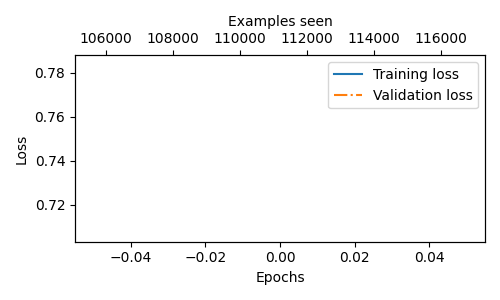

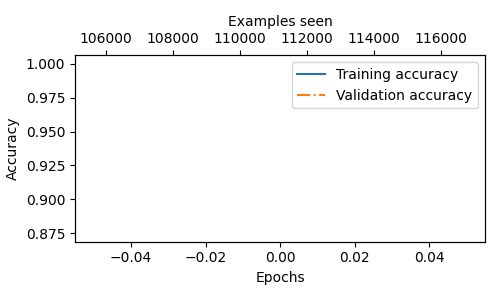

plot: py.Module = <module 'matplotlib.pyplot' from '/usr/local/lib/python3.12/site-packages/matplotlib/pyplot.py'>
defined type Figure
defined type Axis
lossExamplesSeen: List[Long] = List(111200L)
trainingLoss: List[Double] = List(0.7839783430099487)
validationLoss: List[Double] = List(0.7070853114128113)
accuracyExamplesSeen: List[Long] = List(111200L)
trainingAccuracy: List[Double] = List(1.0)
validationAccuracy: List[Double] = List(0.875)
defined function plotValues

In [57]:
val plot = py.module("matplotlib.pyplot")
  
type Figure = py.Dynamic
type Axis = py.Dynamic

val (lossExamplesSeen, trainingLoss, validationLoss) = trainingEpochs.flatMap(_.trainingSteps).map {
  case TrainingStep(Loss(trainingLoss, validationLoss), examplesSeen) => (examplesSeen, trainingLoss, validationLoss)
}.unzip3

val (accuracyExamplesSeen, trainingAccuracy, validationAccuracy) = trainingEpochs.map {
  case TrainingEpoch(trainingSteps, Accuracy(trainingAccuracy, validationAccuracy)) => 
    (trainingSteps.last.examplesSeen, trainingAccuracy, validationAccuracy)
}.unzip3

def plotValues(examplesSeen: List[Long], trainingValues: List[Double], validationValues: List[Double], label: String) =
  try {
    val epochs = torch.linspace(0, trainingEpochs.length, examplesSeen.length)
    val (figure, axis1) = plot.subplots(figsize = (5, 3)).as[(Figure, Axis)]
    axis1.plot(epochs, trainingValues.toPythonProxy, label = s"Training $label")
    axis1.plot(epochs, validationValues.toPythonProxy, linestyle = "-.", label = s"Validation $label")
    axis1.set_xlabel("Epochs")
    axis1.set_ylabel(label.capitalize)
    axis1.legend()
    val axis2 = axis1.twiny()
    axis2.plot(examplesSeen.toPythonProxy, trainingValues.toPythonProxy, alpha = 0)
    axis2.set_xlabel("Examples seen")
    figure.tight_layout()
    DisplaySupport.showPlot(plot)
  } catch {
    case e: py.PythonException =>
      println("(!) If the exception below says 'Numpy is not available', restart the Jupyter kernel. It's an issue with Matplotlib in Jupyter.\n")
      throw e
  }

plotValues(lossExamplesSeen, trainingLoss, validationLoss, label = "loss")
plotValues(accuracyExamplesSeen, trainingAccuracy, validationAccuracy, label = "accuracy")

In [58]:
val trainingAccuracy = calculateDataLoaderAccuracy(model, device)(trainingLoader, batchesCountOpt = Some(10))
println(f"Training accuracy: ${trainingAccuracy * 100}%.2f%%")
val validationAccuracy = calculateDataLoaderAccuracy(model, device)(validationLoader, batchesCountOpt = Some(10))
println(f"Validation accuracy: ${validationAccuracy * 100}%.2f%%")
val testAccuracy = calculateDataLoaderAccuracy(model, device)(testLoader, batchesCountOpt = Some(10))
println(f"Test accuracy: ${testAccuracy * 100}%.2f%%")

Training accuracy: 95.00%
Validation accuracy: 82.50%
Test accuracy: 91.25%


trainingAccuracy: Double = 0.95
validationAccuracy: Double = 0.825
testAccuracy: Double = 0.9125

In [70]:
def classifySpam(
  model: Model,
  tokenizer: Tokenizer,
  maxLength: Option[Int] = None,
  paddingTokenId: Int = 50_256
)(
  text: String
) = {
  model.eval()
  val encodedText = tokenizer.encode(text).as[Seq[Int]].toVector
  val padToLength = maxLength.getOrElse(trainingDataset.maxLength.as[Int])
  val paddedEncodedText = encodedText.padTo(padToLength, paddingTokenId)
  val inputTensor = torch.tensor(paddedEncodedText.toPythonProxy).unsqueeze(0)
  val logits = py.`with`(torch.no_grad()) { _ =>
    model(inputTensor)
  }
  val predictedClass = torch.argmax(py"$logits[:, -1, :]", dim = -1).item()
  if (predictedClass == 1)
    print("[SPAM] ")
  println(text)
}

val text1 = "You are a winner you have been specially\n selected to receive $1000 cash or a $2000 award."
classifySpam(model, tokenizer)(text1)

println()

val text2 = "Hey, just wanted to check if we're still on\n for dinner tonight? Let me know!"
classifySpam(model, tokenizer)(text2)

You are a winner you have been specially
 selected to receive $1000 cash or a $2000 award.

Hey, just wanted to check if we're still on
 for dinner tonight? Let me know!


defined function classifySpam
text1: String = """You are a winner you have been specially
 selected to receive $1000 cash or a $2000 award."""
text2: String = """Hey, just wanted to check if we're still on
 for dinner tonight? Let me know!"""